In [1]:
import numpy as np
import tqdm
import torch
import argparse
from flowNetsRAFT256_SS import RAFT256_SS
from flowNetsRAFT256 import RAFT256
import matplotlib.pyplot as plt

from torchvision.utils import flow_to_image

In [2]:
device = torch.device('cuda', 0)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('-n', '--nodes', default=1, type=int,
                    help='number of compute nodes')
parser.add_argument('-g', '--gpus', default=2, type=int,
                    help='number of gpus per node')
parser.add_argument('--name', type=str, default='RAFT-PIV256_test_test1',
                    help='name of experiment')
parser.add_argument('--input_path_ckpt', type=str,
                    default='./precomputed_ckpts/RAFT256-PIV_ProbClass2/ckpt.tar',
                    help='path of already trained checkpoint')
parser.add_argument('--recover', type=eval, default=True,
                    help='Wether to load an existing checkpoint')
parser.add_argument('--output_dir_results', type=str, default='./test_results/',
                    help='output directory of test results')

parser.add_argument('--test_dataset', type=str, default='cylinder',
                    choices=['backstep', 'cylinder', 'jhtdb', 'dns_turb', 'sqg', 'tbl', 'twcf'],
                    help='test dataset to evaluate')
parser.add_argument('--plot_results', type=eval, default=True,
                    help="""Whether or not to plot predicted results.""")

parser.add_argument('--amp', type=eval, default=False, help='Wether to use auto mixed precision')
parser.add_argument('-a', '--arch', type=str, default='RAFT256', choices=['RAFT256'],
                    help='Type of architecture to use')
parser.add_argument('--batch_size', default=5, type=int)
parser.add_argument('--batch_size_test', default=1, type=int)
parser.add_argument('--split_size', default=1, type=int)
parser.add_argument('--offset', default=256, type=int,
                    help='interrogation window size')
parser.add_argument('--shift', default=64, type=int,
                    help='shift of interrogation window in px')

parser.add_argument('--iters', default=16, type=int,
                    help='number of update steps in ConvGRU')
parser.add_argument('--upsample', type=str, default='convex',
                    choices=['convex', 'bicubic', 'bicubic8', 'lanczos4', 'lanczos4_8'],
                    help="""Type of upsampling method""")
args = parser.parse_args([])

In [18]:
# read lamb-oseen flow field
case = '../RAFT_SS/data/oseen_3000.0.npz'
data = np.load(case)
element = ['img1', 'img2', 'u', 'v']
img1, img2, u, v = [data[x] for x in element]
flows = np.stack((u,v),axis=0)

img1 = torch.from_numpy(img1).float()
img1 = img1.repeat(1,1,1,1)
img2 = torch.from_numpy(img2).float()
img2 = img2.repeat(1,1,1,1)
flows = torch.from_numpy(flows).float()
flows = flows.unsqueeze(dim=0)

# to gpu
img1, img2, flows = [x.to(device) for x in [img1,img2,flows]]

print(
    img1.shape,
    img2.shape,
    flows.shape, sep='\n'
)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


In [19]:
img1 = img1 / 255
img2 = img2 /255
imgs = torch.stack((img1,img2),dim=1)
imgs = torch.squeeze(imgs, dim=2)
imgs.shape

torch.Size([1, 2, 256, 256])

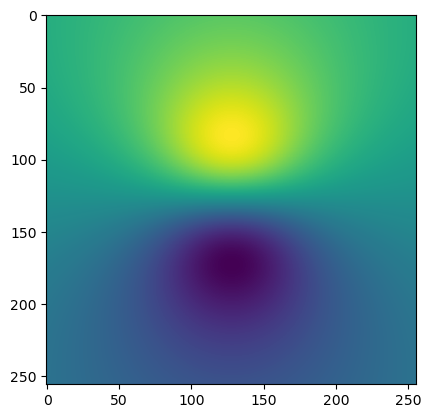

In [20]:
gt = flows.detach().cpu().numpy()
plt.imshow(gt[0,0,:,:])
plt.show()

In [21]:
model = RAFT256_SS(args=args).to(device)
checkpoint = torch.load('./results/RAFT256-PIV_SS_ProbClass2/ckpt.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

pred_flows = model(imgs, flows, args=args, evaluate=False)

all_flow_iters = pred_flows[0]
predicted_flows = all_flow_iters[-1]
# allocate memory of predicted images
i_batch = 1
B, C, H, W = imgs.size()
predicted_flows = torch.zeros_like(imgs).cuda()
total_test_samples = 0
sum_test_epe = .0

# debug
# print(all_flow_iters[-1].shape)
# print(all_flow_iters[-1][0,0,:10,:10])

# compute epe
# test_epe_loss = torch.sum((predicted_flows[:, :, :,:] - flows[:, :, :,:]) ** 2,
#                           dim=1).sqrt().view(-1).mean().item()
# # epe_array[i_batch*B:i_batch*B+B] = test_epe_loss
# total_test_samples += B
# sum_test_epe += test_epe_loss * B
# total_test_epe_loss = sum_test_epe / total_test_samples
test_epe_loss = torch.sum(torch.square(predicted_flows-flows),dim=1).sqrt().mean().item()
print(test_epe_loss)
print(pred_flows[1][0], pred_flows[1][1], sep='\n')

# vector field
pred_flows = model(imgs, flows, args=args, evaluate=True)
all_flow_iters = pred_flows[0]
test_epe_loss = torch.sum(torch.square(predicted_flows-flows),dim=1).sqrt().mean().item()
print(test_epe_loss)
print(pred_flows[1][0], pred_flows[1][1], sep='\n')

4.952634334564209
tensor(1.0830, device='cuda:0', grad_fn=<AddBackward0>)
{'epe': 0.33690619468688965, '1px': 0.955230712890625, '3px': 1.0, '5px': 1.0}
4.952634334564209
tensor(0.6563, device='cuda:0', grad_fn=<AddBackward0>)
{'epe': 0.1948227435350418, '1px': 0.9986114501953125, '3px': 1.0, '5px': 1.0}


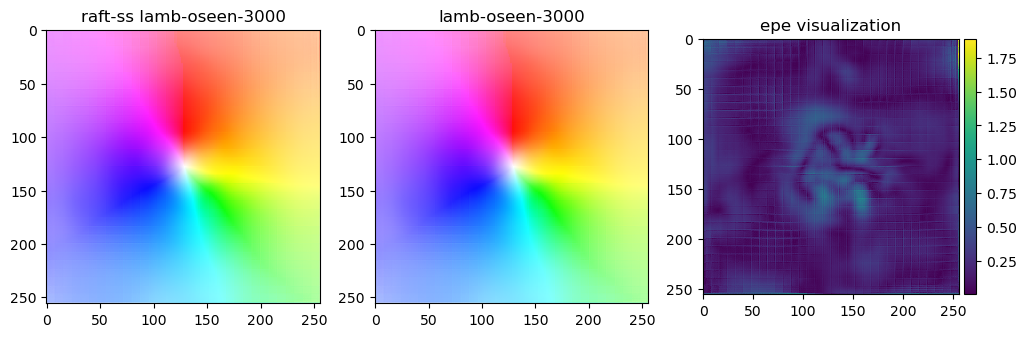

In [22]:
def locatable_axes_easy(ax):
    """ adopted from https://matplotlib.org/3.5.0/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py """
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax)

    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)
    return ax_cb

flowImg = all_flow_iters[-1]
flowImg = flow_to_image(flowImg)
flowImg = flowImg.permute(0,2,3,1)
flowImg = flowImg.squeeze(dim=0)
flowImg = flowImg.detach().cpu().numpy()
flowImg.shape

flowGt = flows
flowGt = flow_to_image(flowGt)
flowGt = flowGt.permute(0,2,3,1)
flowGt = flowGt.squeeze(dim=0)
flowGt = flowGt.detach().cpu().numpy()

plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(flowImg)
plt.title('raft-ss lamb-oseen-3000')

plt.subplot(132)
plt.imshow(flowImg)
plt.title('lamb-oseen-3000')

epe = torch.sum((all_flow_iters[-1] - flows)**2,dim=1).sqrt()
epe = epe.squeeze(dim=0)
epe = epe.detach().cpu().numpy()

ax = plt.subplot(133)
im = plt.imshow(epe)
plt.title('epe visualization')
plt.colorbar(im, cax=locatable_axes_easy(ax))
plt.show()

In [23]:
model= RAFT256(args=args).to(device)
checkpoint = torch.load('./results/ckpt.tar')
model.load_state_dict(checkpoint['model_state_dict'])

pred_flows = model(imgs, flows, args=args)
all_flow_iters = pred_flows[0]
predicted_flows = all_flow_iters[-1]
# allocate memory of predicted images
i_batch = 1
B, C, H, W = imgs.size()
predicted_flows = torch.zeros_like(imgs).cuda()
total_test_samples = 0
sum_test_epe = .0

# compute epe
# test_epe_loss = torch.sum((predicted_flows[:, :, :,:] - flows[:, :, :,:]) ** 2,
#                           dim=1).sqrt().view(-1).mean().item()

test_epe_loss = torch.sum(torch.square((predicted_flows-flows)),dim=1).sqrt().mean().item()
# epe_array[i_batch*B:i_batch*B+B] = test_epe_loss
total_test_samples += B
sum_test_epe += test_epe_loss * B
total_test_epe_loss = sum_test_epe / total_test_samples

# print(all_flow_iters[-1][0,0,:10,:10])
print(test_epe_loss)
print(pred_flows[1][0], pred_flows[1][1], sep='\n')

4.952634334564209
tensor(0.8946, device='cuda:0', grad_fn=<AddBackward0>)
{'epe': 0.2966356575489044, '1px': 0.9826202392578125, '3px': 1.0, '5px': 1.0}


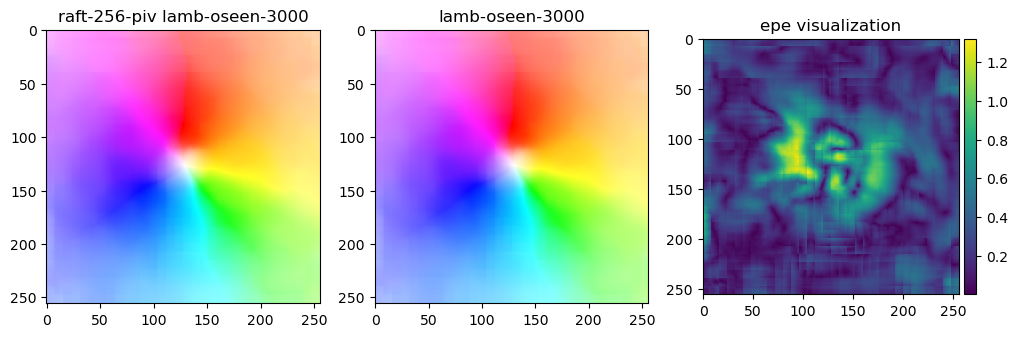

In [24]:
flowImg = all_flow_iters[-1]
flowImg = flow_to_image(flowImg)
flowImg = flowImg.permute(0,2,3,1)
flowImg = flowImg.squeeze(dim=0)
flowImg = flowImg.detach().cpu().numpy()
flowImg.shape

flowGt = flows
flowGt = flow_to_image(flowGt)
flowGt = flowGt.permute(0,2,3,1)
flowGt = flowGt.squeeze(dim=0)
flowGt = flowGt.detach().cpu().numpy()

plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(flowImg)
plt.title('raft-256-piv lamb-oseen-3000')

plt.subplot(132)
plt.imshow(flowImg)
plt.title('lamb-oseen-3000')

epe = torch.sum((all_flow_iters[-1] - flows)**2,dim=1).sqrt()
epe = epe.squeeze(dim=0)
epe = epe.detach().cpu().numpy()

ax = plt.subplot(133)
im = plt.imshow(epe)
plt.title('epe visualization')
plt.colorbar(im, cax=locatable_axes_easy(ax))
plt.show()